# La Régression Logistique, un problème de classification

Quelques liens pour plus de détails :
* [Overfitting](https://github.com/maximiliense/lmpirp/blob/main/Notes/Overfitting.pdf)
* [Dimension VC](https://github.com/maximiliense/lmpirp/blob/main/Notes/dimension_vapnik_chervonenkis.pdf)

## Introduction

Dans cette partie, nous allons implémenter un algorithme de classification supervisée. Contrairement à la régression linéaire qui consiste à prédire une valeur scalaire, la régression logistique a pour but d'estimer la probabilité d'une variable catégorielle. Une variable catégorielle correspond à un nombre entier compris entre $1$ et $K$ pour un problème à $K$ classes d'objets où la notion de proximité (1 est plus proche de 2 que de 3) est oubliée. Nous considererons ici un cas simple à deux classes. Puis nous mettrons en place un classificateur de chiffre manuscrit compris entre 0 et 9.

**La régression logistique** cherche à estimer la probabilité $\mathbb{P}(y=1|\boldsymbol{x})$ où $y\in\{0,1\}$. On obtient la probabilité inverse de la manière suivante : $\mathbb{P}(y=0|\boldsymbol{x})$=1-$\mathbb{P}(y=1|\boldsymbol{x})$. Pour cela, on suppose que le paramètre naturel $\eta$ de notre loi est estimable à partir d'une combinaison linéaire des variables explicatives :
\begin{equation*}
\exists\boldsymbol{\beta}\in\mathbb{R}^d,\ \eta(\boldsymbol{x}) = \langle\boldsymbol{\beta}, \boldsymbol{x}\rangle
\end{equation*}

La fonction de lien $\sigma$ est la fonction qui permet du passer du paramètre naturel à notre probabilité. Dans le cas d'une loi de Bernoulli (loi d'une variable binaire), la fonction de lien est la sigmoid :
\begin{equation}
\begin{aligned}
\sigma:\mathbb{R}&\mapsto \big[0, 1\big]\\
z&\Rightarrow (1+\text{exp}(-z))^{-1}
\end{aligned}
\end{equation}

La fonction sigmoid est illustrée par la figure suivante.

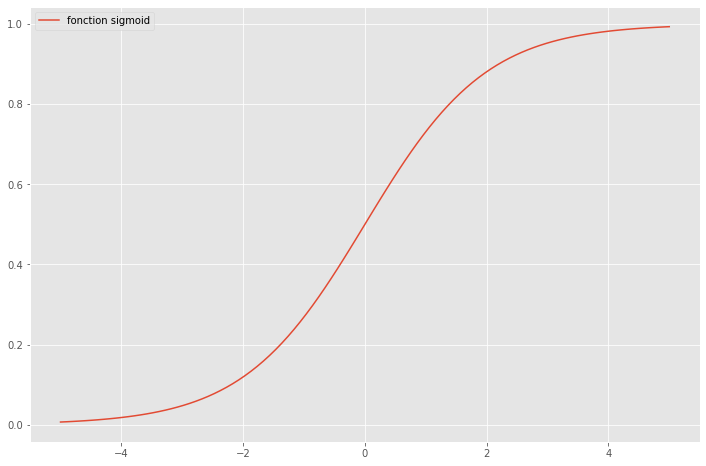

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# configuration generale de matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('ggplot')

x = np.linspace(-5, 5, 100)
y = (1+np.exp(-x))**(-1)
plt.plot(x, y, label="fonction sigmoid")
plt.legend()
plt.show()

Ainsi, si le paramètre naturel $\eta$ est négatif, la probabilité estimée sera inférieur à $0.5$ et notre échantillon appartiendra plus probablement à la classse $0$ ($y=0$). À l'inverse, si $\eta$ est positif, on dira que notre échantillon appartient à la classe positive.

il est ainsi possible d'obtenir notre probabilité de la manière suivante :

\begin{equation}
\mathbb{P}(y_{\text{new}}=1|\boldsymbol{x_{\text{new}}}, \boldsymbol{\beta})=\sigma(\boldsymbol{\beta}^T\boldsymbol{x_{\text{new}}} ).
\end{equation}

De la même manière que pour la régression linéaire, on supposera que le vecteur $\boldsymbol{x}$ possède une dimension $0$ avec la valeur $1$ faisant office de biais.

---
On dit que deux vecteurs $u$ et $v$ sont orthogonaux si leur produit scalaire est nul :
\begin{equation}
\langle u, v \rangle = 0
\end{equation}

La frontière de décision est l'ensemble de tous les points qu'il n'est pas possible de classer $1$ ou $0$. C'est l'ensemble des points tels que $\mathbb{P}(y=1|\boldsymbol{x}, \boldsymbol{\beta})=0.5$. Dit encore autrement, et en nous référant à la figure ci-dessus, il s'agit de l'ensemble des points tels que le paramètre naturel estimé $\eta(\boldsymbol{x})=\boldsymbol{\beta}^T\boldsymbol{x}=0$. Dit encore autrement, il s'agit de l'ensemble des points orthogonaux au vecteur de paramètres $\boldsymbol{\beta}$. Le vecteur $\boldsymbol{\beta}$ est appelé vecteur normal à l'hyperplan séparateur.  

---

La régression logistique nous donne la probabilité $\mathbb{P}(y_{\text{new}}=1|\boldsymbol{x_{\text{new}}}, \boldsymbol{\beta})$. Il est trivial d'obtenir la classe à partir de ce score. On dira que l'échantillon appartient à la classe $1$ si la probabilité est supérieure à $0.5$ et à la classe $0$ dans le cas contraire.

## Construction d'un jeu de données

Considérons le modèle génératif suivant :
\begin{equation}
\boldsymbol{\beta} \sim \mathcal{N}(0, 1)^3 \in \mathbb{R}^3
\end{equation}
Nos échantillons sont simulés via une loi normale de moyenne centrée sur la frontière de décision. Notons $\boldsymbol{\beta^\prime}=\begin{bmatrix}\beta_1\\ \beta_2\end{bmatrix}$. On fixera cette moyenne de la manière suivante :
\begin{equation}
\boldsymbol{\mu}=\boldsymbol{\beta^\prime}\Bigg(-\frac{\beta_0}{\lVert \boldsymbol{\beta^\prime}\rVert^2}
\Bigg).
\end{equation}

---

<span style="color:blue">**Exercice :**</span> **Vérifier qu'on obtient bien :
\begin{equation}
\langle \boldsymbol{\beta^\prime}, \boldsymbol{\mu}\rangle + \beta_0=0
\end{equation}
Dit autrement, il s'agit de vérifier que $\boldsymbol{\mu}$ est bien sur la frontière.**

<span style="color:green">**Réponse :**</span>

---

La moyenne de notre loi normale étant maintenant fixée, nous pouvons simuler nos données :
\begin{equation}
\boldsymbol{x}\sim\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{1})\in\mathbb{R}^2
\end{equation}

La classe d'un échantillon est donnée par :
\begin{equation}
y_i=\left\{
                \begin{array}{ll}
                  1\text{ si }\langle\boldsymbol{\beta^\prime},\boldsymbol{x_i}\rangle +\beta_0>0\\
                  0\text{ sinon.}
                \end{array}
              \right.
\end{equation}

Notre problème est donc par construction totalement linéairement séparable dans le sens où la frontière de décision définie par le vecteur normal $\boldsymbol{\beta^\prime}$ et par le biais $\beta_0$ sépare totalement et sans erreur notre jeu de données.

Le code ci dessous affiche le jeux de données ainsi que la représentation graphique de la frontière de decision $f(x)=-\frac{\beta_1}{\beta_2}x_1-\frac{\beta_0}{\beta_2}$. On vérifie facilement que le vecteur construit tel que $\beta_2=f(x)$ pour $\beta_1$ et $\beta_0$ quelconques (à part les cas particuliers) sont bien sur la frontière.

In [ ]:
import numpy as np

real_beta = np.random.normal(0, 1, size=3)

def sample_data(n, beta):
    # constructing mean 
    mu = beta[1:3]*(-beta[0]/(np.linalg.norm(beta[1:3])**2))
    # covariance is the same for each class
    cov  = np.diag(np.ones(2))
    
    # sampling x and adding the bias
    X = np.insert(np.random.multivariate_normal(mu, cov, size=n), 0, 1, axis=1)
    
    # the label is deterministic
    y = (np.dot(X, beta)>0)*1
    
    return X, y
    
X, y = sample_data(100, real_beta)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('ggplot')

def plot(X, y, beta=None, predictor=None, title=None):
    ymin_ = X[:,2].min()
    ymax_ = X[:,2].max()
    min_ = X[:,1].min()
    max_ = X[:,1].max()
    
    if predictor is not None:
        h = 0.02
        xx, yy = np.meshgrid(np.arange(min_, max_, h), np.arange(ymin_, ymax_, h))
        Z = predictor.predict(np.insert(np.c_[xx.ravel(), yy.ravel()], 0, 1, axis=1))
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z,shading='auto', alpha=0.01)
    
    plt.scatter(X[:,1], X[:,2], c=y)
    
    if beta is not None:
        x_ = np.linspace(min_, max_, 500)
        y_  = -beta[0]/beta[2] - x_ * beta[1] / beta[2]
        plt.plot(x_, y_)
    
    if title is not None:
        plt.title(title)
    plt.xlim(min_, max_)
    plt.ylim(ymin_, ymax_)
    plt.show()
plot(X, y, real_beta)

## Fonction objectif et gradient

De la même manière que pour la régression nous pouvons obtenir notre fonction objectif à partir de la formulation de la vraisemblance de notre problème :
\begin{equation}
\mathcal{L}_{\boldsymbol{\beta}}(\mathcal{S})=\prod_{(\boldsymbol{x}, y)\in\mathcal{S}}\mathbb{P}(y=1|\boldsymbol{x},\boldsymbol{\beta})^y\mathbb{P}(y=0|\boldsymbol{x},\boldsymbol{\beta})^{1-y}
\end{equation}

Le paramètre maximisant la vraisemblance est aussi celui minimisant la log vraisemblance négative :
\begin{equation}
-\text{log}\big(\mathcal{L}_{\boldsymbol{\beta}}(\mathcal{S})\big)=-\sum_{(\boldsymbol{x}, y)\in\mathcal{S}}y\text{log}(p)+(1-y)\text{log}(1-p)
\end{equation}

où $p=\mathbb{P}(y=1|\boldsymbol{x},\boldsymbol{\beta})=\sigma(\boldsymbol{\beta}^T\boldsymbol{x})$. Cette fonction objectif, ou *loss* s'appelle la *cross entropy* ou entropie croisée. On obtient donc :
\begin{equation}
\hat{\boldsymbol{\beta}}=\text{argmin}_{\boldsymbol{\beta}}\Big[-\sum_{(\boldsymbol{x}, y)\in\mathcal{S}}y\text{log}(\sigma(\boldsymbol{\beta}^T\boldsymbol{x}))+(1-y)\text{log}(1-\sigma(\boldsymbol{\beta}^T\boldsymbol{x}))\Big]
\end{equation}

---
<span style="color:blue">**Question 1 :**</span> **Compléter la méthode $\texttt{val}$ de l'objet $\texttt{CrossEntropy}$ ci-dessous.**


<span style="color:blue">**Question 2 :**</span> **Calculez les dérivées partielles $\frac{\partial J(\beta)}{\partial \beta_0}$ et $\frac{\partial J(\beta)}{\partial \beta_1}$ de la fonction de coût de notre modèle de régréssion linéaire. Complétez la méthode $\texttt{grad}$ de l'objet $\texttt{CrossEntropy}$ ci dessous.**

**<span style="color:orange">Indice</span>**  Rappellez-vous que la dérivée d'une composition de fonction s'écrit $(g \circ f)\prime (x) = f\prime(x) g\prime(f(x))$ et que la fonction de coût de notre modèle s'écrit:

\begin{equation}
J(\boldsymbol{\beta}) = \frac{1}{n}\sum_j^n g_1(f_{\boldsymbol{\beta}}(x_j)) + g_2(f_{\boldsymbol{\beta}}(x_j))
\end{equation}

avec $g$, $f$, etc. choisis intelligemment.

**<span style="color:green">Réponse:</span>**

<span style="color:blue">**Question 2${}^\star$ :**</span> **Calculez le gradient de la fonction $J(\boldsymbol{\beta})$ en utilisant les dérivées matricielles et modifiez la méthode $\texttt{grad}$ ci-dessous en conséquence.**

**<span style="color:green">Réponse:</span>**


<span style="color:blue">**Question 3 :**</span> **Complétez la méthode $\texttt{predict}$ de l'objet ci-dessous**

---

In [ ]:
class CrossEntropy(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.idx = np.array([i for i in range(self.X.shape[0])])
        self._pos = 0
        
    def _format_ndarray(arr):
        arr = np.array(arr) if type(arr) is not np.ndarray else arr
        return arr.reshape((arr.shape[0], 1)) if len(arr.shape) == 1 else arr
    
    def predict(self, X):
    
        ####### Complete this part ######## or die ####################
        y_pred = 
        ###############################################################

        return y_pred
    
    def _sigmoid(X, beta):
        return (1+np.exp(-np.dot(X, beta)))**(-1)
    
    def val(self, beta):
        beta = CrossEntropy._format_ndarray(beta)

        ####### Complete this part ######## or die ####################
        p = CrossEntropy._sigmoid(self.X, beta)
        log_p = 
        return 
        ###############################################################
    
    def _shuffle(self):
        np.random.shuffle(self.idx)
    
    def grad(self, beta, batch_size=-1):
        batch_size = self.X.shape[0] if batch_size == -1 else batch_size
        idx = self.idx[self._pos:self._pos+batch_size]

        self._pos = (self._pos+batch_size) % self.X.shape[0]
        if self._pos == 0:
            self._shuffle()
            
        X, y = self.X[idx], self.y[idx]
        y = CrossEntropy._format_ndarray(y)

        
        beta = CrossEntropy._format_ndarray(beta)
        
        ####### Complete this part ######## or die ####################
        grad = 
        return 
        ###############################################################
    

l = CrossEntropy(X, y)
print('La valeur de la loss pour beta est', l.val(real_beta))
print('Le gradient pour beta est\n', l.grad(real_beta))

## Optimisation et dynamique de la descente de gradient dans le cas séparable

Récupérons l'algorithme de descente de gradient développé lors du TP 1. Il s'agit exactement du même code à la différence près qu'on optimise la fonction $\texttt{CrossEntropy}$ et non $\texttt{LeastSquare}$.

In [ ]:
class GradientDescent(object):
    init = np.random.uniform(-4, 4, size=3).reshape((3, 1))
    def __init__(self, X, y, loss=CrossEntropy):
        self.loss = loss(X, y)
        
    def optimize(self, learning_rate = 0.5, nb_iterations=10, beta=init, batch_size=-1):
        param_trace = [beta.T[0]]
        loss_trace = [self.loss.val(beta)]
        for i in range(nb_iterations):
            beta = beta - learning_rate * self.loss.grad(beta, batch_size=batch_size)
            param_trace.append(beta.T[0])
            loss_trace.append(self.loss.val(beta))
            
        return param_trace, loss_trace


gd = GradientDescent(X, y)

La dimension de l'espace des paramètres est $3$ et il n'est plus possible de visualiser ce dernier pour voir si notre algorithme d'optimisation fonctionne. 

---
<span style="color:blue">**Exercice :**</span> **Proposez une stratégie permettant d'évaluer la convergence de notre algorithme. Jouez sur le *learning rate* et sur le nombre d'itérations afin d'améliorer la qualité de notre estimateur.**

---

In [ ]:
####### Complete this part ######## or die ####################

###############################################################

---

Analysons maintenant l'évolution de notre paramètres en terme de distance par rapport au "vrai" paramètre ainsi que l'évolution de la *loss* pour plusieurs configurations d'apprentissage.

In [ ]:
distance = []
loss_evolution = []
for it in range(10, 1000, 10):
    params, loss_trace = gd.optimize(nb_iterations=it, learning_rate=1.)
    distance.append(np.linalg.norm(params[-1]-real_beta))
    loss_evolution.append(loss_trace[-1])
plt.figure()
plt.plot(list(range(10, 1000, 10)),distance)
plt.title("Distance Euclidienne entre les parametres estimes et la vraie solution en fonction du"+
          " nombre d'itérations")
plt.show()
plt.figure()
plt.title("Évolution de la loss en fonction du nombre d'itérations")
plt.plot(list(range(10, 1000, 10)), loss_evolution)
plt.show()

On remarque que notre vecteur de paramètres se rapproche dans un premier temps de la vraie solution puis s'en écarte inéxorablement. Il est légitime de se poser la question du bug dans l'algorithme. Cependant, l'affichage de la *loss* nous montre que plus on s'écarte du vrai paramètre, plus notre modèle *fit* correctement les données. De plus un affichage de la frontière de décision ainsi calculée montre que notre frontière de décision semble visuellement assez proche de la vraie solution.

In [ ]:
plot(X, y, params[-1], title='Solution estimee')
plot(X, y, real_beta, title='Vraie solution')

Il se produit donc un phénomène qu'il convient de comprendre. Ce phénomène est en réalité le pendant du régime interpolatoire (i.e. 0 erreur) de la régression linéaire pour la régression logistique.

Étudions cela plus en détails.

---
<span style="color:blue">**Exercice 1 :**</span> **Montrer que si $\beta$ est le vecteur normal d'un hyperplan qui sépare correctement (i.e. aucune erreur) les deux classes de notre jeu de données, alors $k\beta,\ k\in\mathbb{R}^{\star+}$ est aussi un vecteur normal séparateur pour notre jeu de données.**

<span style="color:green">**Réponse :**</span>

<span style="color:blue">**Exercice 2 :**</span> **Montrer que si $\beta$ est le vecteur normal d'un hyperplan qui sépare correctement (i.e. aucune erreur) les deux classes de notre jeu de données, alors $J(\beta)>J(k\beta)$ si $k>1$.**

<span style="color:green">**Réponse :**</span>

---

Autrement dit, s'il existe un vecteur $\beta$ qui définit une bonne frontière de décision avec aucune erreur, alors tout vecteur $\gamma=k\beta,\ k>0$ définira le même hyperplan. De plus, plus $k$ sera grand, plus notre loss sera petite. Cela nous indique qu'en réalité, la fonction $J(\beta)$ n'admet **aucun** minimum ou, d'un point de vue statistique, le maximum de vraisemblance n'existe pas. On se rapproche du minimum de la fonction $J$ lorsque $\beta$ diverge vers l'infini.

D'un point de vue purement prédictif/classification, cela n'est pas gênant car toutes ces solutions définissent le même hyperplan qui n'est décrit que par la direction du vecteur $\beta$. D'un point de vue statistique, cela est plus gênant car les "probabilités" retournées par notre modèle convergent toutes soit vers $1$ soit vers $0$ et ne sont plus interprétables.

La figure suivante montre que bien que notre vecteur de paramètres diverge, son cosinus avec le vrai vecteur de paramètres tend vers $1$ : ils sont donc bien colinéaires.

In [ ]:
cos = []
for it in range(10, 1000, 10):
    params, loss_trace = gd.optimize(nb_iterations=it, learning_rate=1.)
    cos.append(np.dot(params[-1], real_beta)/(np.linalg.norm(params[-1])*np.linalg.norm(real_beta)))
plt.figure()
plt.title("Cosinus entre les parametres estimes et la vraie solution")
plt.plot(list(range(10, 1000, 10)), cos)
plt.show()

## Optimisation et dynamique de la descente de gradient dans le cas non-séparable

À l'inverse, si le problème n'était pas séparable, une solution optimale existerait et notre algorithme s'en serait approché. Cette solution serait notre maximum de vraisemblance statistique.

---
<span style="color:blue">**Exercice :**</span> **Soit $\beta^\star$ le minimum de notre fonction $J$ tel qu'il existe un unique échantillon $(\boldsymbol{x}, y)$ mal classé. Montrer que $J(k\beta^\star)$ diverge lorsque $k$ tend vers l'infini.**

<span style="color:green">**Réponse :**</span>

---
L'exercice précédent se généralise assez facilement dans un cadre général.

### Construction d'un jeu de données non-séparable

Considérons tout d'abord le modèle génératif suivant:

\begin{equation}
\boldsymbol{x^+} \sim \mathcal{N}(\mu^+, 1)^2 \in \mathbb{R}^2, \boldsymbol{x^-} \sim \mathcal{N}(\mu^-, 1)^2 \in \mathbb{R}^2
\end{equation}

Les échantillons $\boldsymbol{x^+}$ sont associés à $y=1$ et $\boldsymbol{x^-}$ à $y=0$. La variable $y$ est notre variable binaire à expliquer. Le centre de chaque *cluster* est défini de la manière suivante :
\begin{equation}
\boldsymbol{\mu^{+/-}}=\boldsymbol{\beta^\prime}\Bigg(-\frac{\beta_0}{\lVert \boldsymbol{\beta^\prime}\rVert^2}\pm\rho
\Bigg),
\end{equation}

où $\rho$ nous permet de contrôler l'écart du centre de chaque cluster avec la frontière de décision. De la même manière que précédemment, nous choissons une règle arbitraire pour générer aléatoirement les paramètres du "vrai" modèle en incluant un biais:

\begin{equation}
\boldsymbol{\beta} \sim \mathcal{N}(0, 1)^3 \in \mathbb{R}^3
\end{equation}

Ainsi $\beta_1$ et $\beta_2$ correspondent aux paramètres associés à nos variables explicatives et $\beta_0$ est le biais.

In [ ]:
real_beta = np.random.normal(0, 1, size=3)

def sample_data(n, beta, rho=1):
    # constructing mean of each class
    mu_1 = beta[1:3]*((-beta[0]/(np.linalg.norm(beta[1:3])**2))-rho)
    mu_0 = beta[1:3]*((-beta[0]/(np.linalg.norm(beta[1:3])**2))+rho)
    # covariance is the same for each class
    cov  = np.diag(np.ones(2))
    
    # the two classes have the same number of samples
    X = np.concatenate([
        np.random.multivariate_normal(mu_1, cov, size=int(n/2)),
        np.random.multivariate_normal(mu_0, cov, size=int(n/2))
    ], axis=0)
    
    # the label is deterministic
    y = np.array([0 if i < int(n/2) else 1 for i in range(2*int(n/2))])
    
    # we shuffle the samples
    idx = [i for i in range(X.shape[0])]
    np.random.shuffle(idx)
    
    # we insert a bias
    return np.insert(X[idx], 0, 1, axis=1), y[idx]
    
X, y = sample_data(1000, real_beta, rho=2)

In [ ]:
plot(X, y, real_beta)

on retrace les mêmes courbes que nous avions réalisées précédemment et on constate la différence.

In [ ]:
gd = GradientDescent(X, y)

In [ ]:
distance = []
loss_evolution = []
cos = []
for it in range(10, 1000, 10):
    params, loss_trace = gd.optimize(nb_iterations=it, learning_rate=1.)
    distance.append(np.linalg.norm(params[-1]-real_beta))
    loss_evolution.append(loss_trace[-1])
    cos.append(np.dot(params[-1], real_beta)/(np.linalg.norm(params[-1])*np.linalg.norm(real_beta)))
plt.figure()
plt.plot(list(range(10, 1000, 10)),distance)
plt.title("Distance Euclidienne entre les parametres estimes et la vraie solution en fonction du"+
          " nombre d'itérations")
plt.show()
plt.figure()
plt.title("Évolution de la loss en fonction du nombre d'itérations")
plt.plot(list(range(10, 1000, 10)), loss_evolution)
plt.show()

plt.figure()
plt.title("Cosinus entre les parametres estimes et la vraie solution")
plt.plot(list(range(10, 1000, 10)), cos)
plt.show()

On remarque qu'on ne converge pas vers le vecteur que nous avions utilisé lors de la construction du jeu de données. Cela est du au fait que nous ne nous sommes servi de ce vecteur que pour positionner l'hyperplan. Ainsi, nous avons utilisé sa direction et non sa norme. Rajoutons que maintenant le problème n'est plus séparable et notre vecteur estimé converge vers une valeur. On peut également confirmer que le problème n'est plus séparable car notre *loss* ne tend plus vers 0.

## Transformation des variables explicatives

Considérons maintenant un jeu de données tel qu'il n'est pas possible de séparer nos deux classes linéairement.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sample_data(n, sigma1=0.1, sigma2=0.3, r=2):
    class_1 = np.random.uniform(0, 2*np.pi, size=(int(n/2), 1))
    class_1 = np.concatenate(
        [r*np.cos(class_1), r*np.sin(class_1)], axis=1) + np.random.normal(0, 
                                                                       sigma1, 
                                                                       size=(int(n/2), 2))
    class_2 = np.random.normal(0, sigma2, size=(int(n/2), 2))
    X = np.insert(np.concatenate([class_1, class_2]), 0, 1, axis=1)
    y = np.array([1 if i < int(n/2) else 0 for i in range(2*int(n/2))])
    
    return X, y
    
X, y = sample_data(100)
plot(X, y)

On remarque assez naïvement et rapidement qu'une simple régression logistique n'est plus une solution acceptable.

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=False)
model.fit(X, y)
plot(X, y, beta=model.coef_[0])

---
<span style="color:blue">**Exercice :**</span> **Proposez une transformation polynomiale de vos variables explicatives permettant de résoudre correctement ce problème.**

---

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

####### Complete this part ######## or die ####################
model = 

###############################################################

plot(X, y, predictor=model)

## Classificateur de chiffres manuscrits : Le dataset MNIST

#### Chargement du dataset

In [ ]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)

#### Visualisation d'un exemple representatif du jeu de données

In [ ]:
X_img = np.reshape(X,(X.shape[0],28*28))

#Recuperation du nombre d'exemples d'apprentissage ainsi que la dimension des vecteurs
n_samples = X.shape[0]
print("Nombre d'exemples d'apprentissage n_samples = %d " % n_samples)

def plotImg(X):
    plt.figure(figsize=(7.195, 3.841), dpi=100)
    for i in range(200):
        plt.subplot(10,20,i+1)
        plt.imshow(X[i,:].reshape([28,28]), cmap='gray')
        plt.axis('off')
    plt.show()
    plt.close()
    
plotImg(X_img)
    
n_classes = np.max(y) + 1
print("Nombre de classes d'objets n_classes = %d " % n_classes)

#### Construction d'un ensemble de test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

---
<span style="color:blue">**Exercice :**</span> **Proposez un modèle de classification permettant de correctement classer nos chiffres. N'hésitez pas à jouer avec de notions non abordées dans ce TP (e.g. régularisation).**

---

#### Model fit

In [ ]:
####### Complete this part ######## or die ####################

###############################################################

#### model test

In [ ]:
####### Complete this part ######## or die ####################

###############################################################

In [ ]:

print("On teste le modele sur 200 images de test selectionnees aleatoirement")

idx = [i for i in range(X_test.shape[0])]

np.random.shuffle(idx)
n_test_visu = 10

predicted = model.predict(X_test[idx][:n_test_visu])

plt.figure(figsize=(12, 17.14), dpi=100)
for i in range(n_test_visu):
    plt.subplot(n_test_visu,1,i+1)
    plt.title('Predicted:' + str(predicted[i]))
    plt.imshow(X_test[idx][i,:].reshape([28,28]), cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(hspace=1)